<a href="https://colab.research.google.com/github/DomMc97/Car_Data/blob/master/NN%5CNN_Clasification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Classification

A classification of the quality of car from a set of descriptors using a Neural Network classifier.

The data set contains a record of the rating of a series of cars by a car dealer into the following categories: 'unacceptable', 'acceptable', 'good', or 'very good' this is the target. The data set also contains the following descriptors for each car:

* buying: buying price
* maint: price of the maintenance
* doors: number of doors
* persons: capacity in terms of persons to carry
* lug_boot: the size of luggage boot
* safety: estimated safety of the car

---

## Set Up

Import Libraries

In [2]:
# scientific library
import numpy as np

# data analytics library
import pandas as pd

# sklearn functions
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# pytorch functions
from torch import from_numpy, max, save, load
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets design of figures

# libraries for saving/loading data
import pickle
from google.colab import drive

In [3]:
%%capture
# installs skorch for
! [ ! -z "$COLAB_GPU" ] && pip install torch skorch

from skorch import NeuralNetClassifier

Mount Google Drive.

In [4]:
# mount drive
drive.mount('/content/drive')

# root of all file paths used in notebook
root = '/content/drive/My Drive/Methods for Data Science/CW2/Data/'

Mounted at /content/drive


Asks user whether this is the first run of the code to avoid repeat computations.

In [5]:
# code reapeats until a valid input is inserted for the question.
while True:
    init_run = input('Is this the first run of the code y/n?\n')

    if init_run == 'y':
        init_run = True
        break
    elif init_run == 'n':
        init_run = False
        break
    else:
        print('Invalid input.\n')

Is this the first run of the code y/n?
y


Importation of processed data.

In [6]:
# upload files
X_train = np.load(root + 'X_train.npy')
y_train = np.load(root + 'y_train.npy')

PyTorch requires the data to be in a tensor format so I will transfer the training data to the tensor format.

In [7]:
# convert X_train to a tensor
X_train = from_numpy(X_train).float()

# convert y_train to a tensor
y_train = from_numpy(y_train).float()

## Overview of Neural Networks

I will use a feed-forward neural network (NN) on the training set to classify each car in the training set based on the six descriptors.

A feed-foward Neural Network is network of Perceptrons which process a sample with the aim of making a prediction of a class from the set of predictors. 

<u> Perceptron </u>

For the forward propagation of data through the network the perceptrons take the input and apply a variety of calculations on the data. 

The inputs firstly undergo a weighted summation, these are weights to be trained, an add a bias variable to the summation. The bias term allows the 
shifting of the value of the summation.

This summation is then fed into a non-linear function called the activation function. This function introduces a non-linearity to the model, this enables the recognition of non-linear relationships through non-linear decision boundaries. 

The activation function I will employ is the ReLU function: $ReLu(x) = \max(0, x)$  a function which overcomes the vanishing gradient problem and has better sensitivity to sum inputs than other functions such as the sigmoid and tanh functions, allowing models to learn faster and perform better. It is also compuationally in-expensive.



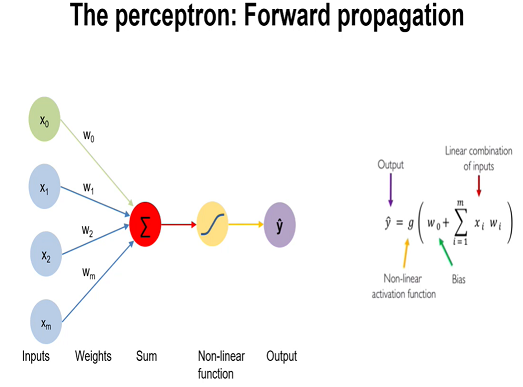

<u> Multi-Layer Perceptron </u>

This perception can be generalised to a multi-layer perceptron. This is where we have multiple layers of these neurons applying different weights and possibly differnt functions to the same data to produce a new set of variables. This layer of new variables is known as a hidden layer. 

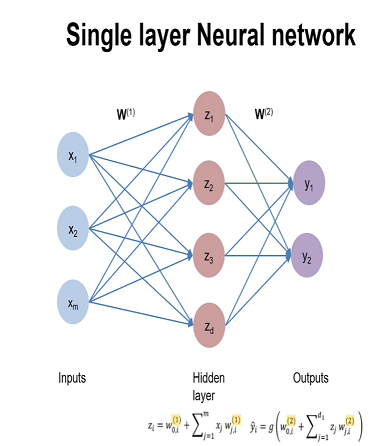

<u> Neural Network </u>

We can stack many of these hidden layers to produce a deep neural network of multi-layer perceptrons.



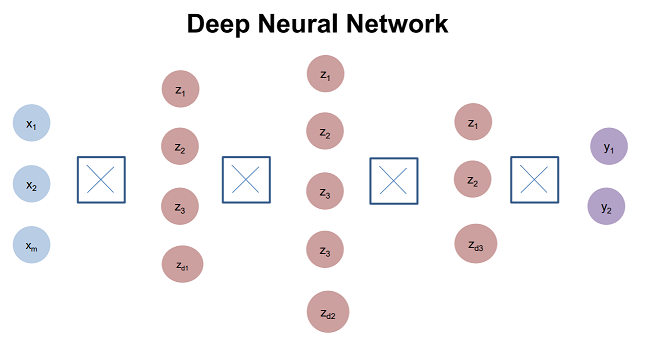

<u> Training the Network </u>

From this network we desire a set of weights for each layer which optimises the quality of the model. We do this through the mimimisation of a loss function. We often calculate the loss as the mean of loss function for a set of samples input into the network. With the loss function quantifying the difference between the predicted and actual outcome.

The loss function I will use is the Cross-Entropy (CE) Loss for multi-classes. CE loss measures the performance of a classification model whose output is a set of probability values between 0 and 1. CE loss increases as the predicted probability diverges from the actual label. CE loss penalizes errors, especially those of predictions that are confident and wrong. Mathematically it is formulated as follows: $$-\sum_{c=1}^{M} y_{o,c}log(p_{o,c})$$
Where,

*   $M$ - number of possible class labels
*    $y_{o,c}$ - a binary indicator of whether class label $c$ is the correct classification for observation $o$
* $p_{o,c}$ - the model's predicted probability that observation $o$ is of class $c$

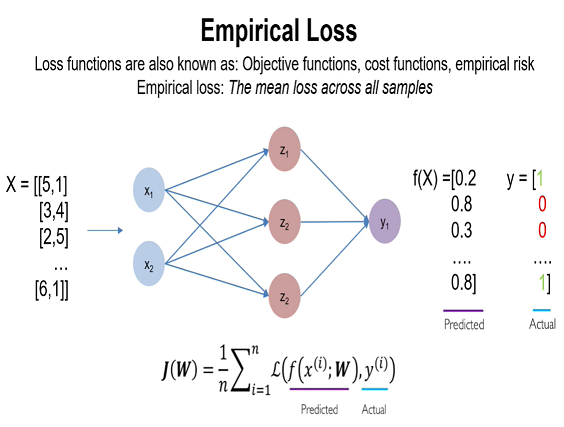

<u> Gradient Descent </u>

To minimize this weight an optimisier method must be employed. I will employ the iterative method, gradient descent.

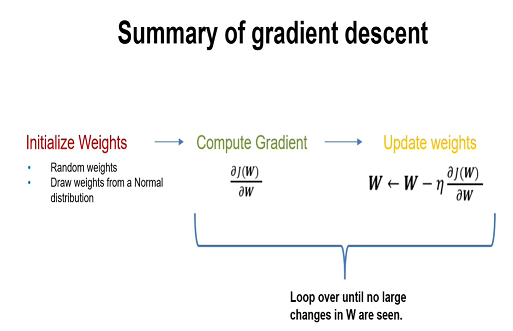

The gradient is calculated using backpropagation. This is a method used to find the errors based on the original inputs by finding the gradients between each neuron of the network. The gradient of errors from the input is found through the application of the chain rule to back propagate the errors through the neurons of the network.

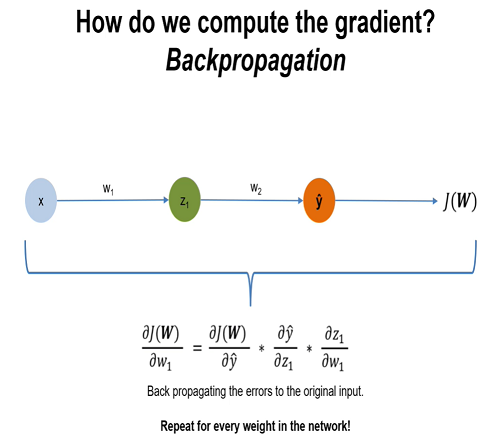

The learning rate, $\eta$, controls how large a step we make towards the minimum at each iteration of the gradient descent. $\eta$ is ideally set in such a way that we have a quick convergence to a minimum. An $\eta$ which is too small will update the weights at miniscule increments resulting in a slow convergence to the local minimum. On the other hand an $\eta$ which is too large will result in the weight changes being too drastic at each step resulting in a the loss value attained 'bouncing' around the local minimum in the loss landscape.


Calculating the average gradient for an entire data set then updating the weights is extremely computationally expensive and results in an incredibly slow learning process. Therefore Batch gradient descent is employed this is an alteration of the gradient descent method where weights are updated after the working through a subset of data set instead of it's entirety. The batch size is therefore a hyperparameter that defines the number of samples to work through before updating the internal model parameters. The number of epochs is then a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. An epoch being comprised of one or more batches.

## Neural Network

My task is to create a network of two hidden layers, each with 200 neurons. With ReLUas the activation function. The optimisation method to be fixed as stochastic gradient descent (SGD), and define the
loss function as cross-entropy. I will train on batches of 64 data points with a learning rate of 0.01 for 120 epochs.



---



### Network and Training Functions

Create Neural Network of 2 hidden layers each with 200 neurons and ReLu activation functions.

In [16]:
class NN(nn.Module):
  # define hidden layers with relu activation function
  def __init__(self):
        super().__init__()
        # input of 6 descriptors to hidden layer weights
        self.W1 = nn.Linear(6, 200)
        # hidden layer to hidden layer weights
        self.W2 = nn.Linear(200, 200)
        # hidden layer to 4 multi-class outputs
        self.W3 = nn.Linear(200, 4)
  # forward pass through network
  def forward(self, x):
        out = F.relu(self.W1(x))
        out = F.relu(self.W2(out))
        out = F.relu(self.W3(out))
        return out

# function to reset parameters of the network
def weight_reset(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()

# call the network
net = NN()

A function for training and validation of the model.

In [8]:
def net_train(net, train_loader, valid_loader, lr):
    """ A function to train and get final validation accuracy of a neural   
    network.
    Inputs:
        net: Pytorch Neural Network.
        train_loader: A Pytorch loader of training data prepared into bathces.
        valid_loader: A Pytorch loader of validation data prepared into bathces.
    Outputs:
        loss_values: array of mean cross-entropy losses per epoch.
        valid_acc: Validation accuracy of the trained model on the data set. 
    """
    # define loss function as cross-entropy
    loss_function = nn.CrossEntropyLoss()

    # define optimiser as SGD
    optimiser = SGD(net.parameters(), lr=lr)

    # reset model parameters
    net.apply(weight_reset)

    # valuses of mean loss for an epoch
    loss_values = []

    # run model for 120 epochs
    for epoch in range(1, 121):
        # training part
        net.train()
        
        # initialise values for training loss
        train_loss = []

        # run batch optimisation
        for data, target in train_loader:
             # converts rating to long type
            target = target.long()

            # set gradient to 0
            optimiser.zero_grad()

            # forward propagation
            out = net(data)

            # loss calculation
            loss = loss_function(out, target)

            # backward propagation
            loss.backward()

            # optimise weights
            optimiser.step()

            # add loss to a list of losses for epoch
            train_loss.append(loss.item())
        
        # mean loss of epoch
        mean_loss = np.mean(train_loss)

        # add loss to list of mean losses for an epoch
        loss_values.append(mean_loss) 

        #print results of epoch
        print('Epoch: [{}/120] \t Training Loss: {:.6f}'.format(epoch, mean_loss))
    
    # get validation accuracy of model
    net.eval()

    # correct counter
    correct = 0
    # get correct predictions
    for data, target in valid_loader:
        # get predictions
        out = net(data)
        _, predicted = max(out.data, 1)
        # get correct predictions
        correct += (predicted == target).sum().item()

    # accuracy
    valid_acc = correct/len(valid_loader.dataset)
    
    # print accuracy
    print('\nValidation Accuracy: {:.4f}%'.format(valid_acc*100))

    return loss_values, valid_acc


A function for K-Fold cross validation.

In [17]:
def net_cv(X_train, y_train, net, lr, batch_size):
    
    # get 5-fold splits of the training data
    skf = StratifiedKFold(shuffle=True, random_state=0)
    skf.get_n_splits(X_train, y_train)

    # sum loss and avg sum valid acc
    loss_values_sum = np.zeros(120)
    valid_acc_sum = 0.0

    # iterate through folds
    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        print(
            """
            #########
            Fold: {}
            #########\n
            """.format(i+1))
        # produce a train and validation fold
        X_train_fold, X_valid_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_valid_fold = y_train[train_index], y_train[test_index]
        
        # produce Tensor datasets
        train = TensorDataset(X_train_fold, y_train_fold)
        valid = TensorDataset(X_valid_fold, y_valid_fold)

        # split into batches
        train_loader = DataLoader(train, batch_size=batch_size, shuffle = False)
        valid_loader = DataLoader(valid , batch_size=batch_size, shuffle = False)

        # train models
        loss_values, valid_acc = net_train(net, train_loader, valid_loader, lr)
        
        # update sums
        loss_values_sum += loss_values
        valid_acc_sum += valid_acc
    
    # avg loss values and avg valid acc
    loss_values = loss_values_sum/5
    valid_acc = valid_acc_sum/5

    # print accuracy
    print('\nAverage Validation Accuracy: {:.4f}%'.format(valid_acc*100))

    return loss_values, valid_acc

### Initial Training

Train on batches of 64 data points with a learning rate of 0.01 for 120 epochs.

In [18]:
%%time
# loss and accuracy values for a benchmark model.
bench_loss, bench_valid_acc = net_cv(X_train, y_train, net, 0.01, 64)


            #########
            Fold: 1
            #########

            
Epoch: [1/120] 	 Training Loss: 1.364491
Epoch: [2/120] 	 Training Loss: 1.368853
Epoch: [3/120] 	 Training Loss: 1.367123
Epoch: [4/120] 	 Training Loss: 1.364338
Epoch: [5/120] 	 Training Loss: 1.361257
Epoch: [6/120] 	 Training Loss: 1.358161
Epoch: [7/120] 	 Training Loss: 1.355709
Epoch: [8/120] 	 Training Loss: 1.352964
Epoch: [9/120] 	 Training Loss: 1.351249
Epoch: [10/120] 	 Training Loss: 1.349283
Epoch: [11/120] 	 Training Loss: 1.347149
Epoch: [12/120] 	 Training Loss: 1.345084
Epoch: [13/120] 	 Training Loss: 1.343560
Epoch: [14/120] 	 Training Loss: 1.341737
Epoch: [15/120] 	 Training Loss: 1.339451
Epoch: [16/120] 	 Training Loss: 1.337383
Epoch: [17/120] 	 Training Loss: 1.335750
Epoch: [18/120] 	 Training Loss: 1.334063
Epoch: [19/120] 	 Training Loss: 1.332544
Epoch: [20/120] 	 Training Loss: 1.330940
Epoch: [21/120] 	 Training Loss: 1.329301
Epoch: [22/120] 	 Training Loss: 1.328015
Epoch:

### Comparison of Learning Rates


Training of the model for a low learning rate of 0.0005.


In [19]:
%%time
# loss and accuracy values for a low lr model.
low_lr_loss, low_lr_valid_acc = net_cv(X_train, y_train, net, 0.0005, 64)


            #########
            Fold: 1
            #########

            
Epoch: [1/120] 	 Training Loss: 1.387724
Epoch: [2/120] 	 Training Loss: 1.387278
Epoch: [3/120] 	 Training Loss: 1.386783
Epoch: [4/120] 	 Training Loss: 1.386293
Epoch: [5/120] 	 Training Loss: 1.385766
Epoch: [6/120] 	 Training Loss: 1.385239
Epoch: [7/120] 	 Training Loss: 1.384685
Epoch: [8/120] 	 Training Loss: 1.384116
Epoch: [9/120] 	 Training Loss: 1.383564
Epoch: [10/120] 	 Training Loss: 1.383014
Epoch: [11/120] 	 Training Loss: 1.382504
Epoch: [12/120] 	 Training Loss: 1.381986
Epoch: [13/120] 	 Training Loss: 1.381478
Epoch: [14/120] 	 Training Loss: 1.380994
Epoch: [15/120] 	 Training Loss: 1.380533
Epoch: [16/120] 	 Training Loss: 1.380068
Epoch: [17/120] 	 Training Loss: 1.379616
Epoch: [18/120] 	 Training Loss: 1.379180
Epoch: [19/120] 	 Training Loss: 1.378748
Epoch: [20/120] 	 Training Loss: 1.378335
Epoch: [21/120] 	 Training Loss: 1.377928
Epoch: [22/120] 	 Training Loss: 1.377524
Epoch:

Training of the model for a high learning rate of 0.95.

In [20]:
%%time
# loss and accuracy values for a high lr model.
high_lr_loss, high_lr_valid_acc = net_cv(X_train, y_train, net, 0.95, 64)


            #########
            Fold: 1
            #########

            
Epoch: [1/120] 	 Training Loss: 1.104779
Epoch: [2/120] 	 Training Loss: 1.386294
Epoch: [3/120] 	 Training Loss: 1.386294
Epoch: [4/120] 	 Training Loss: 1.386294
Epoch: [5/120] 	 Training Loss: 1.386294
Epoch: [6/120] 	 Training Loss: 1.386294
Epoch: [7/120] 	 Training Loss: 1.386294
Epoch: [8/120] 	 Training Loss: 1.386294
Epoch: [9/120] 	 Training Loss: 1.386294
Epoch: [10/120] 	 Training Loss: 1.386294
Epoch: [11/120] 	 Training Loss: 1.386294
Epoch: [12/120] 	 Training Loss: 1.386294
Epoch: [13/120] 	 Training Loss: 1.386294
Epoch: [14/120] 	 Training Loss: 1.386294
Epoch: [15/120] 	 Training Loss: 1.386294
Epoch: [16/120] 	 Training Loss: 1.386294
Epoch: [17/120] 	 Training Loss: 1.386294
Epoch: [18/120] 	 Training Loss: 1.386294
Epoch: [19/120] 	 Training Loss: 1.386294
Epoch: [20/120] 	 Training Loss: 1.386294
Epoch: [21/120] 	 Training Loss: 1.386294
Epoch: [22/120] 	 Training Loss: 1.386294
Epoch:

Comparision of the loss of the 3 models.

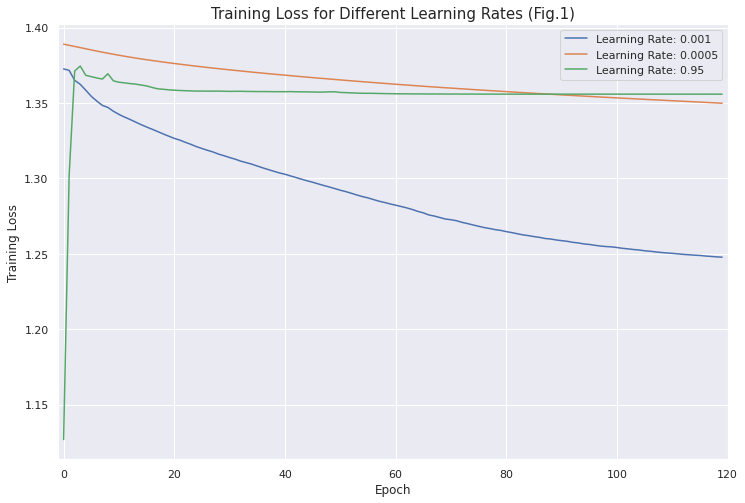

In [21]:
# line plot of average training loss per epoch for 3 different lr
plt.figure(figsize=(12,8))
# set x limits
plt.xlim(-1, 120)

# labels
plt.title('Training Loss for Different Learning Rates (Fig.1)', fontsize=15)
plt.ylabel('Training Loss')
plt.xlabel('Epoch')

# plots
plt.plot(bench_loss, label='Learning Rate: 0.001')
plt.plot(low_lr_loss, label='Learning Rate: 0.0005')
plt.plot(high_lr_loss, label='Learning Rate: 0.95')

# display
plt.legend()
plt.show()

Comparison of the accuracy of the models.

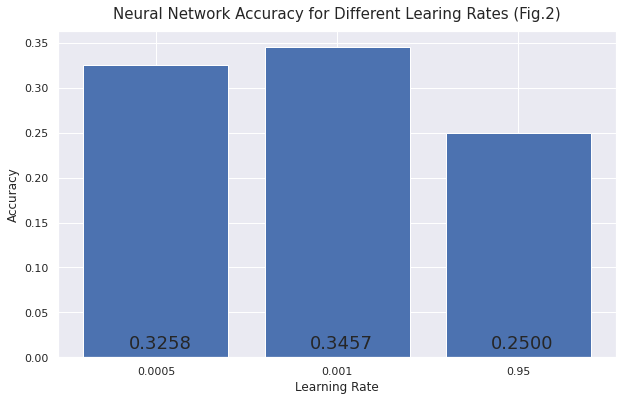

In [44]:
# bar chart of best Lr of model
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# scores and labels
scores = [low_lr_valid_acc, bench_valid_acc, high_lr_valid_acc]
labels = ['0.0005','0.001','0.95']

# plot
ax.bar([0, 1, 2], scores)
plt.xticks([0, 1, 2], labels)

# annotations
for i, v in enumerate(scores):
    ax.text(i-.15, 
              .01, 
              format(scores[i],'.4f'), 
              fontsize=18)

# labels
ax.set_ylabel('Accuracy')
ax.set_xlabel('Learning Rate')
ax.set_title('Neural Network Accuracy for Different Learing Rates (Fig.2)',fontsize='15',y=1.02)
plt.show()

<u> Discussion </u>

An $\eta=0.0005$ is seen to be too small in comparison to $\eta=0.001$ with the updating of the weights not being significant enough at each iteraion resulting in a slow convergence to the local minimum. Fig.1 shows that the final training loss acheived by $\eta=0.0005$ is surpassed by $\eta=0.001$ after 7 epochs. This results in a better validation accuracy for the model trained with a learning rate of $\eta=0.001$.

An $\eta=0.95$ on the otherhand can be inferred as being too high. Fig.2 can be interprted as the loss 'jumping' out of the same local minimum as the other learning rates and then quickly falling to the bottom of one of the suboptimum minima for which the model predicts a single class hence an accuracy of 25%.

### Comparison of Batch Sizes


Training of the model for a low batch size of 2.


In [45]:
%%time
# loss and accuracy values for a small batch model.
low_batch_loss, low_batch_valid_acc = net_cv(X_train, y_train, net, 0.001, 2)


            #########
            Fold: 1
            #########

            
Epoch: [1/120] 	 Training Loss: 1.172186
Epoch: [2/120] 	 Training Loss: 1.268457
Epoch: [3/120] 	 Training Loss: 1.300743
Epoch: [4/120] 	 Training Loss: 1.317283
Epoch: [5/120] 	 Training Loss: 1.314125
Epoch: [6/120] 	 Training Loss: 1.315866
Epoch: [7/120] 	 Training Loss: 1.316371
Epoch: [8/120] 	 Training Loss: 1.309391
Epoch: [9/120] 	 Training Loss: 1.307501
Epoch: [10/120] 	 Training Loss: 1.299086
Epoch: [11/120] 	 Training Loss: 1.289771
Epoch: [12/120] 	 Training Loss: 1.284014
Epoch: [13/120] 	 Training Loss: 1.203700
Epoch: [14/120] 	 Training Loss: 1.152995
Epoch: [15/120] 	 Training Loss: 1.189393
Epoch: [16/120] 	 Training Loss: 1.193622
Epoch: [17/120] 	 Training Loss: 1.145181
Epoch: [18/120] 	 Training Loss: 1.123950
Epoch: [19/120] 	 Training Loss: 1.102221
Epoch: [20/120] 	 Training Loss: 1.103141
Epoch: [21/120] 	 Training Loss: 1.104269
Epoch: [22/120] 	 Training Loss: 1.090627
Epoch:

Training of the model for a high batch size of 256.

In [46]:
%%time
# loss and accuracy values for a high lr model.
high_batch_loss, high_batch_valid_acc = net_cv(X_train, y_train, net, 0.001, 256)


            #########
            Fold: 1
            #########

            
Epoch: [1/120] 	 Training Loss: 1.392346
Epoch: [2/120] 	 Training Loss: 1.392098
Epoch: [3/120] 	 Training Loss: 1.391852
Epoch: [4/120] 	 Training Loss: 1.391593
Epoch: [5/120] 	 Training Loss: 1.391350
Epoch: [6/120] 	 Training Loss: 1.391108
Epoch: [7/120] 	 Training Loss: 1.390867
Epoch: [8/120] 	 Training Loss: 1.390618
Epoch: [9/120] 	 Training Loss: 1.390383
Epoch: [10/120] 	 Training Loss: 1.390142
Epoch: [11/120] 	 Training Loss: 1.389907
Epoch: [12/120] 	 Training Loss: 1.389671
Epoch: [13/120] 	 Training Loss: 1.389428
Epoch: [14/120] 	 Training Loss: 1.389185
Epoch: [15/120] 	 Training Loss: 1.388956
Epoch: [16/120] 	 Training Loss: 1.388734
Epoch: [17/120] 	 Training Loss: 1.388511
Epoch: [18/120] 	 Training Loss: 1.388289
Epoch: [19/120] 	 Training Loss: 1.388069
Epoch: [20/120] 	 Training Loss: 1.387862
Epoch: [21/120] 	 Training Loss: 1.387666
Epoch: [22/120] 	 Training Loss: 1.387478
Epoch:

Comparision of the loss of the 3 models.

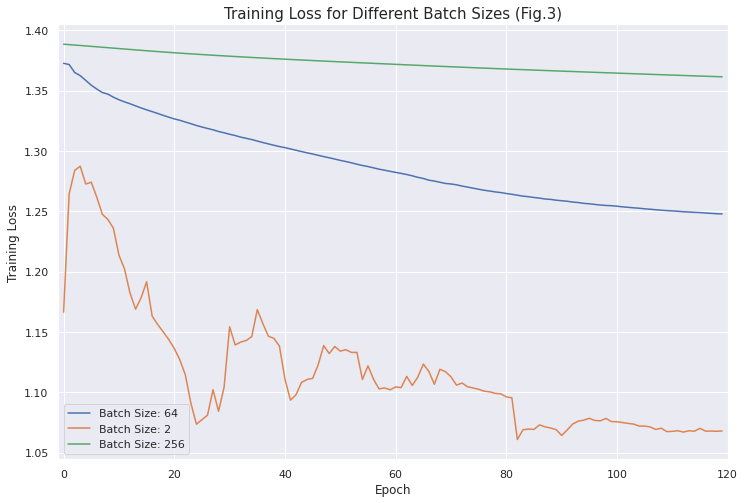

In [47]:
# line plot of average training loss per epoch for 3 different lr
plt.figure(figsize=(12,8))
# set x limits
plt.xlim(-1, 120)

# labels
plt.title('Training Loss for Different Batch Sizes (Fig.3)', fontsize=15)
plt.ylabel('Training Loss')
plt.xlabel('Epoch')

# plots
plt.plot(bench_loss, label='Batch Size: 64')
plt.plot(low_batch_loss, label='Batch Size: 2')
plt.plot(high_batch_loss, label='Batch Size: 256')

# display
plt.legend()
plt.show()

Comparison of the accuracy of the models.

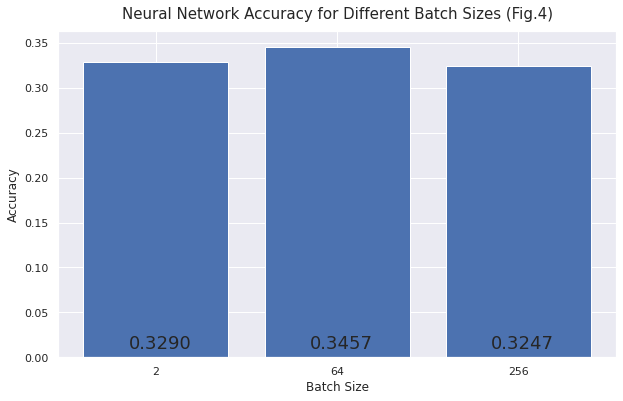

In [48]:
# bar chart of best Lr of model
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# scores and labels
scores = [low_batch_valid_acc, bench_valid_acc, high_batch_valid_acc]
labels = ['2','64','256']

# plot
ax.bar([0, 1, 2], scores)
plt.xticks([0, 1, 2], labels)

# annotations
for i, v in enumerate(scores):
    ax.text(i-.15, 
              .01, 
              format(scores[i],'.4f'), 
              fontsize=18)

# labels
ax.set_ylabel('Accuracy')
ax.set_xlabel('Batch Size')
ax.set_title('Neural Network Accuracy for Different Batch Sizes (Fig.4)',fontsize='15',y=1.02)
plt.show()

<u> Discussion </u>

For a low batch size of 2 we can see a non-smooth convergence of the training loss. This is due to the fact that for a low batch size the model does not receive enough data to accurately determine the gradient of the loss landscape with the weights being updated noisely accoring to the data in the batch.

For a large batch size of 256 on the other hand we have a similar problem to the low learing rate that we are not updating weights frequently enough due to the lack of iterartions resulting in a slow convergence.

The characteristics of the low and high batch sizes result in a worse accuracy performance in comparison to the batch size of 64. 

## Dropout Regularisation

Dropout regularisation can be used to control the fitting of a neural network to the data set in order to reduce over-fitting.

Dropout randomly sets some of the activation neurons to 0 on the foward propagation and their weights not updated upon backpropagation. Drop out prevents a single neuronsfrom becoming over dominant in the predictions. Allowing other neuron weights to be updated in its place.


---




### Network and Cross Validation Functions

Create Neural Network of 2 hidden layers each with 200 neurons and ReLu activation functions and a dropout regularisation of the second hidden layer.

In [8]:
class Drop_NN(nn.Module):
  # define hidden layers with relu activation function
  def __init__(self, dr=0.5, init_run=False):
        super().__init__()
        # input of 6 descriptors to hidden layer weights
        self.W1 = nn.Linear(6, 200)
        # a precusor to hidden layer which performs a dropout with rate dr
        self.dropout = nn.Dropout(p=dr)
        # hidden layer to hidden layer weights
        self.W2 = nn.Linear(200, 200)
        # hidden layer to 4 multi-class outputs
        self.W3 = nn.Linear(200, 4)
        # initilaise weights for consistency
        if init_run:
            save(self.state_dict(), root + 'model_params.sav')
        else:
            self.load_state_dict(load(root + 'model_params.sav'))

  # forward pass through network
  def forward(self, x):
        out = F.relu(self.W1(x))
        out = self.dropout(out)
        out = F.relu(self.W2(out))
        out = F.relu(self.W3(out))
        return out

# initialises a Pytorch dropout network in a Skorch wrapper to allow the use of 
# Sklearn cross-validation methods  
d_net = NeuralNetClassifier(
        Drop_NN(init_run=init_run),
        max_epochs=120,
        batch_size=64,
        criterion = nn.CrossEntropyLoss,
        optimizer = SGD,
        optimizer__lr=0.001 
    )

A function for the optimisation of the drop out rate.

In [9]:
def NN_CV(net, dr, fig_num):
    """ A function which runs 5-fold cross-validation of the accuracy of a 
    Neural Neywork for a range of drop out rates and displays results.
    Inputs:
        net: Neural netowrk with dropout
        dr: array of drop out rates.
        fig_num: a figure number string.
    Output:
      CV: Results of CV.
    """   

    # hyperparameters
    params = {'module__dr' : dr}

    if init_run:
        # grid search of parameters
        CV = GridSearchCV(net, params, scoring='accuracy',
                            cv=StratifiedKFold(shuffle=True, random_state=0))
        CV.fit(X_train, y_train.long())

        # save results
        with open(root + 'NN_CV_' + fig_num + '.sav', 'wb') as fp:
            pickle.dump(CV, fp)
    else:
        # load fitted grid search
        CV = pickle.load(open(root + 'NN_CV_' + fig_num + '.sav', 'rb'))
  
    # print results
    print('Best Score: ', CV.best_score_, '\nBest Parameters: ',
          CV.best_params_)
    
    # create figure
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)

    # make plot
    ax.set_title('Drop Out Rate vs Accuracy for Neural Network (Fig.' + fig_num\
                 + ')', fontsize=15, y=1.02)
    plt.plot(dr, CV.cv_results_['mean_test_score'], marker='o',
             markerfacecolor='r', linestyle='dashed')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Drop Out Rate')

    plt.show()

    return CV

### Cross Validation

I will start with a coarse range of rates between 0.1 and 0.9 a margin just within the maximal interval of rates 0, 1. 

Streaming output truncated to the last 5000 lines.
     84        1.3422       0.2400        1.3885  0.1444
     85        1.3399       0.2422        1.3887  0.1452
     86        1.3429       0.2411        1.3887  0.1334
     87        1.3412       0.2411        1.3888  0.1372
     88        1.3409       0.2422        1.3890  0.1700
     89        1.3395       0.2444        1.3891  0.1685
     90        1.3403       0.2444        1.3892  0.1810
     91        1.3393       0.2444        1.3893  0.1668
     92        1.3399       0.2422        1.3894  0.1353
     93        1.3377       0.2444        1.3896  0.1303
     94        1.3372       0.2456        1.3897  0.1323
     95        1.3370       0.2467        1.3898  0.1435
     96        1.3374       0.2467        1.3899  0.1303
     97        1.3365       0.2467        1.3900  0.1368
     98        1.3369       0.2489        1.3900  0.1311
     99        1.3354       0.2533        1.3901  0.1444
    100        1.3361       0.2611   

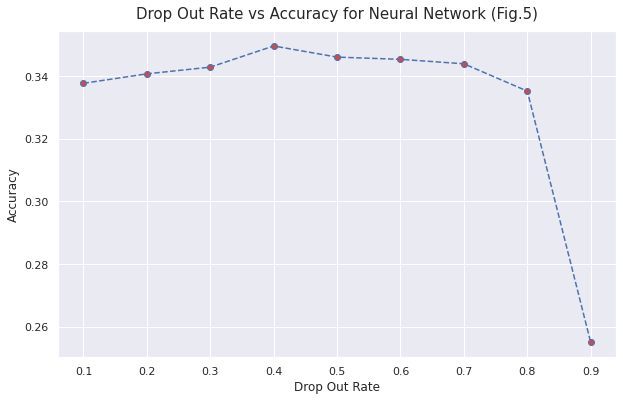

In [22]:
%%time
# range of the drop out rate
dr = np.arange(0.1,1,0.1)

# 5-fold CV to find optimum penalty paramater
_ = NN_CV(d_net, dr, '5')

Tuning of the drop out rate around 0.4.

Streaming output truncated to the last 5000 lines.
     84        1.3460       0.2800        1.3855  0.0889
     85        1.3466       0.2811        1.3855  0.1007
     86        1.3466       0.2822        1.3856  0.0947
     87        1.3445       0.2844        1.3856  0.1032
     88        1.3427       0.2889        1.3857  0.0961
     89        1.3425       0.2889        1.3858  0.1052
     90        1.3452       0.2867        1.3859  0.0990
     91        1.3455       0.2889        1.3860  0.0931
     92        1.3447       0.2889        1.3860  0.0939
     93        1.3425       0.2867        1.3861  0.1062
     94        1.3430       0.2900        1.3863  0.0905
     95        1.3423       0.2900        1.3863  0.1013
     96        1.3402       0.2900        1.3864  0.0957
     97        1.3422       0.2900        1.3866  0.0916
     98        1.3422       0.2900        1.3866  0.0926
     99        1.3421       0.2867        1.3868  0.0910
    100        1.3414       0.2878   

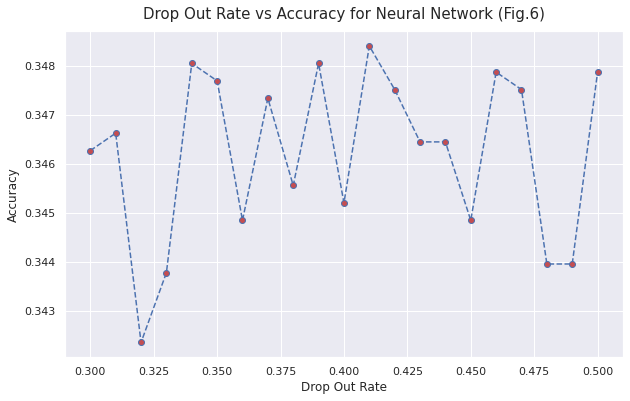

CPU times: user 26min 23s, sys: 11.7 s, total: 26min 35s
Wall time: 26min 34s


In [11]:
%%time
# range of the drop out rate
dr = 0.4 + np.arange(-0.1,0.11,0.01)

# 5-fold CV to find optimum penalty paramater
CV = NN_CV(d_net, dr, '6')

# optimum trained model 
opt_net = CV.best_estimator_

# save best model
with open(root + 'NN.sav', "wb") as fp:
    pickle.dump(opt_net, fp)